<a href="https://colab.research.google.com/github/danielgrgurevic/PortafolioDataScience/blob/main/Forecasting_con_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Cargar el dataframe
df = pd.read_csv('/content/drive/MyDrive/Data science/Portafolio Proyectos/NVDA.csv',index_col='Date', parse_dates=['Date'])

In [ ]:
#Mostrar las 5 primeras filas
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-04,71.317497,71.562500,69.044998,69.822502,69.216995,39122000
2018-10-05,69.572502,70.199997,66.885002,67.464996,66.879913,42663600
2018-10-08,66.625000,67.790001,65.019997,66.442497,65.866295,40861200
2018-10-09,66.235001,67.190002,65.699997,66.385002,65.809296,27350000
2018-10-10,65.315002,65.777496,61.400002,61.422501,60.889839,68494000


In [ ]:
df.shape

(1257, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-10-04 to 2023-10-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1257 non-null   float64
 1   High       1257 non-null   float64
 2   Low        1257 non-null   float64
 3   Close      1257 non-null   float64
 4   Adj Close  1257 non-null   float64
 5   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.7 KB


#Pre-Procesamiento de los Datos

In [ ]:
#Crear sets de entrenamiento y validación
set_entrenamiento = df[:'2020'].iloc[:,1:2]
set_validacion = df['2021':].iloc[:,1:2]

In [ ]:
set_validacion.shape

(692, 1)

In [ ]:
#Normalizar datos, usando la librería Scikit-learn, para normalizar valores entre 0 y 1.
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

Para entrenar la red LSTM se tomarán 60 datos consecutivos, los bloques de 60 datos se almacenarán en la varible 'x', mientras que el data 61, el que se va a predecir se almacenará en la variable 'y', y será usado como salida en la red LSTM

In [ ]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

Se re ajustan los sets para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un ventor de 60 x 1

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Implementación del modelo en Keras

Se define el tamaño de los datos de entrada y  del dato de salida, así como el número total de neuronas (50).

In [ ]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')

In [ ]:
historia_entrenamiento = modelo.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
16/16 [==============================] - 3s 8ms/step - loss: 0.0255
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 8/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 9/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 10/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 11/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 12/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 13/50
16/16 [==============================

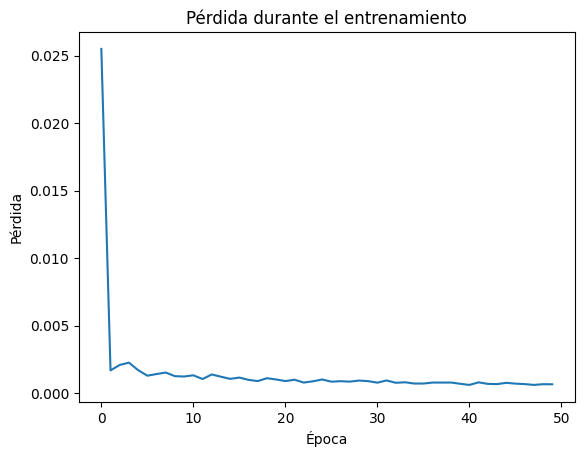

In [ ]:
# Visualización de la pérdida durante el entrenamiento
plt.plot(historia_entrenamiento.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# Predicción del valor de la Acción

Inicialmente debemos preparar el set de validación, normalizando inicialmente los datos, en el rango de 0 a 1, para lo cual usamos la transformación implementada anteriormente sobre el set de entrenamiento

In [ ]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Recordemos que el modelo fue entrenado para tomar 60 y generar un dato como predicción. Así que debemos reorganizar el set de validación (x_test) para que tenga bloques de 60 datos:

In [ ]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Y finalmente realizamos la predicción usando la función predict y aplicamos la normalización inversa de dicha predicción para que esté en la escala real de las acciones:

In [ ]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

20/20 [==============================] - 0s 3ms/step


In [ ]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

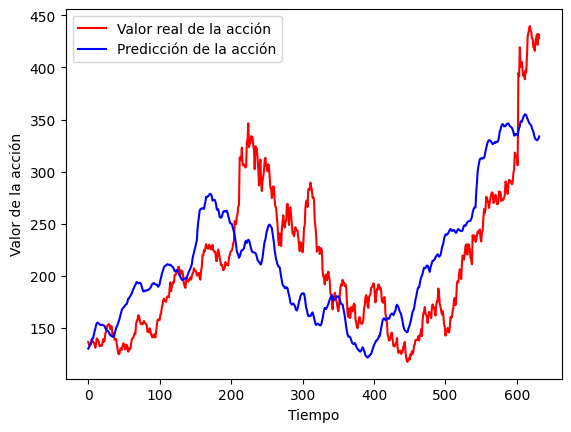

In [ ]:
# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)